In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import statsmodels.stats.proportion

In [2]:
def estimate_coverage(ci_estimator, p, num_samples, num_trials):
    num_correct = 0
    
    for ii in range(num_trials):
        samples = scipy.stats.bernoulli.rvs(p, size=num_samples)
        
        # returns a confidence interval as tuple
        ci_hat = ci_estimator(samples)
        
        if ci_hat[0] <= p and ci_hat[1] >= p:
            num_correct += 1
    
    return num_correct / num_trials


def make_markov_estimator(alpha):
    def estimator(samples):
        p_hat = np.mean(samples)
        n = len(samples)
        eps = math.sqrt(1.0 / (4 * n * alpha))
        return p_hat - eps, p_hat + eps
    return estimator


def make_hoeffding_estimator(alpha):
    def estimator(samples):
        p_hat = np.mean(samples)
        n = len(samples)
        eps = math.sqrt(math.log(2 / alpha) / (2 * n))
        return p_hat - eps, p_hat + eps
    return estimator


def make_clopper_pearson_estimator(alpha):
    def estimator(samples):
        return statsmodels.stats.proportion.proportion_confint(
            np.sum(samples),
            len(samples),
            alpha=alpha,
            method='beta')
    return estimator

In [3]:
scipy.stats.bernoulli.rvs(0.2, size=10)

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [4]:
e = make_markov_estimator(0.05)

print(e(scipy.stats.bernoulli.rvs(0.2, size=100)))

(-0.023606797749978953, 0.423606797749979)


In [5]:
estimate_coverage(make_markov_estimator(0.01), 0.5, 100, 10000)

1.0

In [6]:
estimate_coverage(make_hoeffding_estimator(0.01), 0.5, 100, 10000)

0.9993

In [7]:
estimate_coverage(make_clopper_pearson_estimator(0.05), 0.9, 100, 10000)

/Users/ludo/.pyenv/versions/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ludo/.pyenv/versions/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:621: RuntimeWarning: overflow encountered in _beta_isf
  return _boost._beta_isf(x, a, b)


0.9525

[  100   117   137   161   189   221   259   304   356   418   489   574
   672   788   924  1083  1269  1487  1743  2043  2395  2807  3290  3857
  4520  5298  6210  7279  8532 10000]


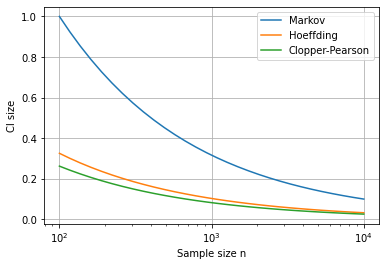

In [8]:
n_vals = np.round(np.geomspace(100, 10000, 30)).astype(int)

def size_markov(n, alpha):
    return 2 * math.sqrt(1.0 / (4 * n * alpha))


def size_hoeffding(n, alpha):
    return 2 * math.sqrt(math.log(2.0 / alpha) / (2 * n))

def size_clopper_pearson(n, alpha):
    tmp = statsmodels.stats.proportion.proportion_confint(n // 2, n, alpha=alpha, method='beta')
    return tmp[1] - tmp[0]


alpha = 0.01
print(n_vals)
s_m = [size_markov(n, alpha) for n in n_vals]
s_h = [size_hoeffding(n, alpha) for n in n_vals]
s_c = [size_clopper_pearson(n, alpha) for n in n_vals]


plt.figure()
plt.grid()
#plt.yscale('log')
plt.xscale('log')
plt.ylabel('CI size')
plt.xlabel('Sample size n')
plt.plot(n_vals, s_m, label='Markov')
plt.plot(n_vals, s_h, label='Hoeffding')
plt.plot(n_vals, s_c, label='Clopper-Pearson')
plt.legend()
plt.show()